In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import scipy
from scipy.optimize import curve_fit

/home/benutzer1/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/benutzer1/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
f = h5py.File('LED_830V.hdf5')
f['all_hits'].dtype.names
mask = f['all_hits']['channel'] == 7

In [3]:
np.sum(mask)

41692

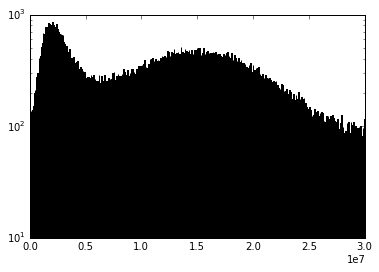

In [11]:
n, bins, _ = plt.hist(f['all_hits']['area'][mask],bins=np.linspace(0,3e7,501))
bin_centers = 0.5*(bins[1:] + bins[:-1])
plt.yscale('log')

#print(f['all_hits']['area'][mask])
#plt.clf()

what is the spe value : 13530000.0
[6.21059001e+02 1.89802644e+06 8.41719828e+05 2.38573741e+02
 3.51250879e+06 1.62746846e+06 4.34640555e+02 1.44944345e+07
 6.24897803e+06 6.72436519e-29 1.43470348e+02]
gain for the selected PMT with selected voltage is:  14494434.478659019


/home/benutzer1/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


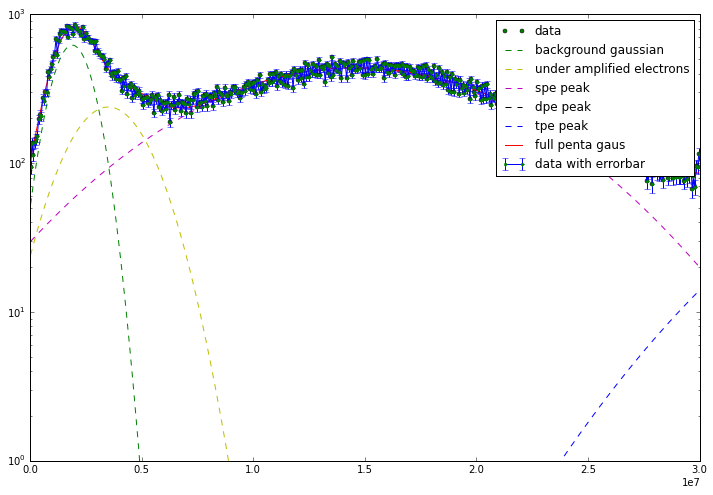

In [12]:
n = list(n)
#in case background peak is smaller than spe peak
        #reduced_for_low_background = n[0:50]
        #print(reduced_for_low_background)
        #h_bgd = max(reduced_for_low_background)
#print(n)
h_bgd= max(n)
index_h_bgd = n.index(h_bgd)
#print(index_h_bgd)
mu_bgd_index = n.index(h_bgd)
mu_bgd = bin_centers[mu_bgd_index]
sigma_bgd = 0
for i in n[mu_bgd_index:]:
    #print(i)
    if i < h_bgd * 0.5:
        FWHM = np.abs(
            bin_centers[n[mu_bgd_index:].index(i) + mu_bgd_index] - bin_centers[n[mu_bgd_index:].index(h_bgd)+ mu_bgd_index])*2
        sigma_bgd +=FWHM / (2 * np.sqrt(2 * np.log(2)))
        #print(n[mu_bgd_index:].index(h_bgd))
        break
        
reduced_list = n[index_h_bgd:100]
#print(reduced_list)
valley=min(reduced_list)
valley_index = n.index(valley)
mu_valley = bin_centers[valley_index]



h_spe = max(n[valley_index:])
mu_spe_index = n.index(h_spe)
mu_spe = bin_centers[mu_spe_index]
sigma_spe = 0
for i in n[mu_spe_index:]:
    if i < h_spe * 0.5:
        FWHM = np.abs(
            bin_centers[n[mu_spe_index:].index(i) + mu_spe_index] - bin_centers[n[mu_spe_index:].index(h_spe)+ mu_spe_index])*2
        sigma_spe +=FWHM / (2 * np.sqrt(2 * np.log(2)))
        break

h_dpe = 0.1*h_spe
h_tpe = 0.5*h_dpe

print('what is the spe value :', mu_spe)
plt.figure(figsize=(12,8))


#########################now check which fit might make sense....###########################

# def tripple_gaus(x, h_bgd, mu_bgd, sigma_bgd, h_spe, mu_spe, sigma_spe, h_dpe):
#         background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
#         spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
#         dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
#         fit_function = background + spe + dpe
#         return fit_function


# def quadra_gaus(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe):
#         background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
#         uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
#         spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
#         dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
#         fit_function = background + uae + spe + dpe
#         return fit_function

# def penta_gaus_mod(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe, h_tpe):
#         background =    h_bgd/(np.sqrt(2*np.pi)*sigma_bgd)*np.exp(-(x-mu_bgd)**2/(np.sqrt(2)*sigma_bgd)**2)
#         uae =           h_uae/(np.sqrt(2*np.pi)*sigma_uae)*np.exp(-(x-mu_uae)**2/(np.sqrt(2)*sigma_uae)**2)
#         spe =           h_spe/(np.sqrt(2*np.pi)*sigma_spe)*np.exp(-(x-mu_spe)**2/(np.sqrt(2)*sigma_spe)**2)
#         dpe =           h_dpe/(np.sqrt(2*np.pi)*2*sigma_spe)*np.exp(-(x-2*mu_spe)**2/(np.sqrt(2)*2*sigma_spe)**2)
#         tpe =           h_tpe/(np.sqrt(2*np.pi)*3*sigma_spe)*np.exp(-(x-3*mu_spe)**2/(np.sqrt(2)*3*sigma_spe)**2)
#         fit_function = background + uae + spe + dpe + tpe
#         return fit_function
def penta_gaus(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe, h_tpe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
        dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
        tpe =           h_tpe             * np.exp(-(x - 3 * mu_spe) ** 2    / (3 * 2 * sigma_spe ** 2))
        fit_function = background + uae + spe + dpe + tpe
        return fit_function


def single_gaus(x, h, mu, sigma):
    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus

#print(scipy.__version__)
#popt, pcov = curve_fit(tripple_gaus, bin_centers, n, p0=[h_bgd,mu_bgd,sigma_bgd, h_spe, mu_spe,sigma_spe,200])
#popt, pcov = curve_fit(quadra_gaus, bin_centers, n, p0=[h_bgd,mu_bgd,sigma_bgd, 500, 5e6, 1e6,h_spe, mu_spe,sigma_spe,200])

p0=[h_bgd,mu_bgd,sigma_bgd, 500, 5e6, 1e6,h_spe, mu_spe,sigma_spe,h_dpe, h_tpe]
boundaries = ((0, 0, 0, 0, 0, 0, 0, 0.9*mu_spe, 0, 0, 0), 
              (np.inf, np.inf, np.inf, h_bgd, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf))


popt, pcov = curve_fit(penta_gaus, bin_centers, n, p0, bounds=boundaries,  sigma=np.maximum(np.sqrt(n), np.ones_like(n)), maxfev=10000)

plt.plot(bin_centers, n, 'go', markersize=4, label= 'data')
plt.plot(bin_centers, (single_gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='background gaussian')
plt.plot(bin_centers, (single_gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='under amplified electrons')
plt.plot(bin_centers, (single_gaus(bin_centers, popt[6], popt[7], popt[8])), 'm--', label='spe peak')
plt.plot(bin_centers, (single_gaus(bin_centers, popt[9], 2*popt[7], popt[8])), 'k--', label='dpe peak')
plt.plot(bin_centers, (single_gaus(bin_centers, popt[10], 3*popt[7], popt[8])), 'b--', label='tpe peak')


#plt.plot(bin_centers, (tripple_gaus(bin_centers, *popt)), 'r-', label='fit')
#plt.plot(bin_centers, (quadra_gaus(bin_centers, *popt)), 'r-', label='fit')
plt.plot(bin_centers, (penta_gaus(bin_centers, *popt)), 'r-', label='full penta gaus')
plt.errorbar(bin_centers, n, yerr=np.sqrt(n), marker= '.', mec='green', mfc= 'green', label='data with errorbar')



plt.yscale('log')
plt.ylim(1)
#ax = plt.gca()
#ax.text(0.1e7, 8e3, 'gain is determined to', popt[7])
print(popt)
print('gain for the selected PMT with selected voltage is: ', popt[7])
plt.legend()
    
plt.show()

